In [ ]:
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import os
from tqdm import tqdm
import cv2

import os
import fnmatch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
np.random.seed(21)

from tensorflow.python.compiler.tensorrt import trt_convert as trt
import time

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Activation,Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import ModelCheckpoint

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip -uq "/content/gdrive/MyDrive/train.zip" -d "/content/gdrive/MyDrive/train_mod"

In [ ]:
!unzip -uq "/content/gdrive/MyDrive/test.zip" -d "/content/gdrive/MyDrive/test_mod"

In [ ]:
import os
folder = '/content/gdrive/MyDrive/'
print((os.path.join(folder,'train_mod')))

/content/gdrive/MyDrive/train_mod


In [ ]:
import fnmatch
def get_train_data(root):

    train_dir = (os.path.join(root,'train_mod'))
    train_label = []
    train_img = []
    label2num = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,
                 'Common Chickweed':4, 'Common wheat':5, 'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,
                 'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}
    for i in os.listdir(train_dir):
      label_number = label2num[i]
      new_path = os.path.join(train_dir,i)
      for j in fnmatch.filter(os.listdir(new_path), '*.png'):
        temp_img = image.load_img(os.path.join(new_path,j), target_size=(128,128))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)
      print(i)
    train_img = np.array(train_img)

    train_y=pd.get_dummies(train_label)
    train_y = np.array(train_y)
    train_img=preprocess_input(train_img)
    
    return train_img,train_y

In [ ]:
train_img,train_y = get_train_data(folder)
print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)

Black-grass
Charlock
Cleavers
Common Chickweed
Common wheat
Fat Hen
Loose Silky-bent
Maize
Scentless Mayweed
Shepherds Purse
Small-flowered Cranesbill
Sugar beet
Training data shape:  (4750, 128, 128, 3)
Training labels shape:  (4750, 12)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

# VGG

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape = (128, 128, 3), include_top = False,weights = 'imagenet',pooling='avg')
vgg.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential

x = layers.Flatten()(vgg.output)

x = layers.Dense(12, activation='softmax')(x)

model = tf.keras.models.Model(vgg.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
batch_size = 64

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001,verbose=2)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=2, mode='min')

vgg_hist = model.fit(datagen.flow(X_train,Y_train),
          batch_size=64,
          epochs=100,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[reduce_lr, early_stop])

Epoch 1/100
134/134 [==============================] - 69s 263ms/step - loss: 3.9598 - accuracy: 0.2185 - val_loss: 2.7136 - val_accuracy: 0.3411
Epoch 2/100
134/134 [==============================] - 22s 167ms/step - loss: 2.1132 - accuracy: 0.3918 - val_loss: 1.9445 - val_accuracy: 0.4442
Epoch 3/100
134/134 [==============================] - 22s 166ms/step - loss: 1.6113 - accuracy: 0.4863 - val_loss: 1.7035 - val_accuracy: 0.4926
Epoch 4/100
134/134 [==============================] - 23s 168ms/step - loss: 1.4665 - accuracy: 0.5357 - val_loss: 1.5867 - val_accuracy: 0.5263
Epoch 5/100
134/134 [==============================] - 22s 166ms/step - loss: 1.3072 - accuracy: 0.5841 - val_loss: 1.3816 - val_accuracy: 0.5768
Epoch 6/100
134/134 [==============================] - 22s 167ms/step - loss: 1.2554 - accuracy: 0.5876 - val_loss: 1.3286 - val_accuracy: 0.5832
Epoch 7/100
134/134 [==============================] - 22s 165ms/step - loss: 1.1556 - accuracy: 0.6213 - val_loss: 1.2550 -

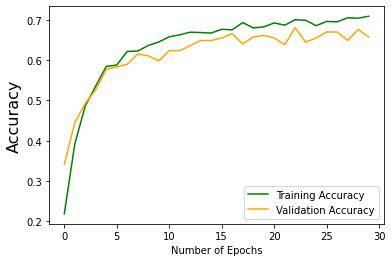

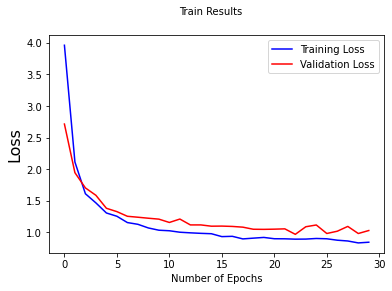

In [ ]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(14,5))

plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(vgg_hist.history['accuracy'], color='green', label='Training Accuracy')
plt.plot(vgg_hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(vgg_hist.history['loss'], color='b', label='Training Loss')
plt.plot(vgg_hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def class_report(m):
    target_names = os.listdir(os.path.join(folder,'train_mod'))
    print(classification_report(Y_valid[:100].argmax(axis=1), m.predict(X_valid[:100]).argmax(axis=1), target_names=target_names))
    
    
from sklearn.metrics import confusion_matrix

def conf_matrix(m):
    target_names = os.listdir(os.path.join(folder,'train_mod'))
    cf_matrix = confusion_matrix(Y_valid.argmax(axis=1), np.round(m.predict(X_valid).argmax(axis=1),0))
    plt.figure(figsize=(20,20))
    sns.heatmap(cf_matrix, annot=True, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

class_report(model)

                           precision    recall  f1-score   support

              Black-grass       0.61      0.73      0.67        15
                 Charlock       1.00      0.62      0.76        13
                 Cleavers       0.56      0.62      0.59         8
         Common Chickweed       0.56      0.69      0.62        13
             Common wheat       0.54      0.88      0.67         8
                  Fat Hen       1.00      0.33      0.50         3
         Loose Silky-bent       1.00      1.00      1.00         2
                    Maize       0.50      0.67      0.57         3
        Scentless Mayweed       0.56      0.75      0.64        12
          Shepherds Purse       0.80      0.36      0.50        11
Small-flowered Cranesbill       0.60      0.50      0.55         6
               Sugar beet       1.00      0.50      0.67         6

                 accuracy                           0.64       100
                macro avg       0.73      0.64      0.64    

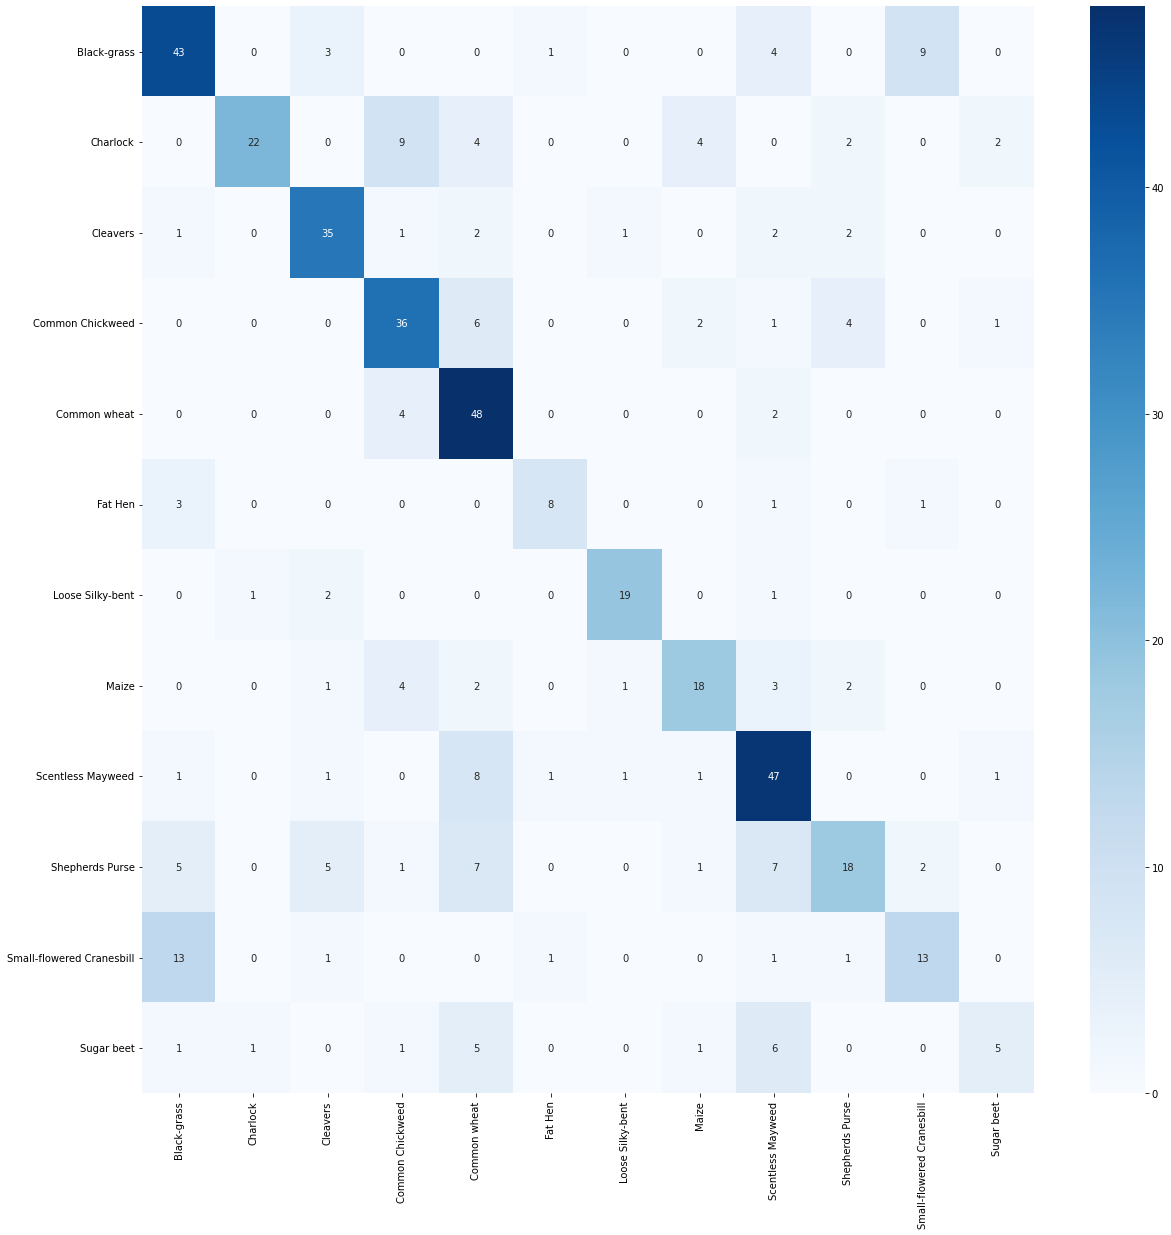

In [ ]:
conf_matrix(model)

In [ ]:
model.save('vgg_model')

INFO:tensorflow:Assets written to: vgg_model/assets


Optimization of VGG Model with TensorRT

TF-TRT FP32 model

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=80000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/vgg_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

Converting to TF-TRT FP32...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP32/assets
Done Converting to TF-TRT FP32


In [ ]:
!saved_model_cli show --all --dir '/content/vgg_saved_model_TFTRT_FP32'


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 128, 128, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 12)
        name: PartitionedCall:0
  Method name is: tensorflow/serving/predict
W0922 05:47:56.497376 140250421233536 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/resource_v

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
batch_size = 16
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '/content/gdrive/MyDrive/train_mod/Black-grass'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

batched_input shape:  (16, 128, 128, 3)


In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tf.compat.v1.saved_model.tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP32')

Step 0: 43.3ms
Step 50: 43.3ms
Step 100: 43.3ms
Step 150: 43.3ms
Step 200: 43.3ms
Step 250: 43.3ms
Step 300: 43.3ms
Step 350: 43.3ms
Step 400: 43.3ms
Step 450: 43.2ms
Throughput: 369 images/s


TF-TRT FP16 model

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/vgg_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_FP16/assets
Done Converting to TF-TRT FP16


In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP16')

Step 0: 42.6ms
Step 50: 43.0ms
Step 100: 43.1ms
Step 150: 43.1ms
Step 200: 43.2ms
Step 250: 43.2ms
Step 300: 43.2ms
Step 350: 43.2ms
Step 400: 43.2ms
Step 450: 43.2ms
Throughput: 371 images/s


TF-TRT INT8 model

In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/vgg_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

Converting to TF-TRT INT8...
INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: vgg_saved_model_TFTRT_INT8/assets
Done Converting to TF-TRT INT8


In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_INT8')

Step 0: 42.6ms
Step 50: 43.1ms
Step 100: 43.1ms
Step 150: 43.3ms
Step 200: 43.3ms
Step 250: 43.2ms
Step 300: 43.3ms
Step 350: 43.3ms
Step 400: 43.2ms
Step 450: 43.2ms
Throughput: 370 images/s


Model Optimization Using TF-Lite(Post Training Dynamic range quantization)

In [ ]:
import pathlib

In [ ]:
tflite_models_dir = pathlib.Path(os.path.join(os.getcwd(),'tflite_models'))
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
converter_vgg = tf.lite.TFLiteConverter.from_saved_model('./vgg_model')

In [ ]:
vgg16_tflite_file = tflite_models_dir/"vgg16.tflite"
converter_vgg.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
vgg16_tflite_file.write_bytes(converter_vgg.convert())
tflite_quant_model = converter_vgg.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_path='./tflite_models/vgg16.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


In [ ]:
def run_tflite_model(tflite_file, test_image_indices):
    global X_valid

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = X_valid[test_image_index]
        test_label = Y_valid[test_image_index]

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

In [ ]:
def evaluate_model(tflite_file, model_type):
    global X_valid
    global Y_valid

    test_image_indices = range(100) #Loading only 100 images for testing since interpreter.invoke takes a lot of time to complete.
    #Reason for longer execution time: TensorFlow Lite op kernels are optimized for ARM processor.
    predictions = run_tflite_model(tflite_file, test_image_indices)
    
    predictions=pd.get_dummies(predictions)
    predictions = np.array(predictions)
    print(predictions.shape)
    accuracy = accuracy_score(y_true=Y_valid[:100,:], y_pred=predictions) 


    return accuracy

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
op = evaluate_model(vgg16_tflite_file, model_type="Float")
print("Accuracy of TFLite - VGG : {}".format(op))

(100, 12)
Accuracy of TFLite - VGG : 0.64


Post training quantization is used for improving latency as well as model size. This could however lead to lower accuracy.

Model Pruning

In [ ]:
!pip install -q tensorflow-model-optimization

     |████████████████████████████████| 211 kB 6.2 MB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 64
epochs = 100

num_images = len(X_train)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.30,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
prune_low_magnitude_block1_c (None, 128, 128, 64)      3522      
_________________________________________________________________
prune_low_magnitude_block1_c (None, 128, 128, 64)      73794     
_________________________________________________________________
prune_low_magnitude_block1_p (None, 64, 64, 64)        1         
_________________________________________________________________
prune_low_magnitude_block2_c (None, 64, 64, 128)       147586    
_________________________________________________________________
prune_low_magnitude_block2_c (None, 64, 64, 128)       295042    
_________________________________________________________________
prune_low_magnitude_block2_p (None, 32, 32, 128)       1     

In [ ]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_data=(X_valid,Y_valid),
                  callbacks=[callbacks, reduce_lr,early_stop])

Epoch 1/100
67/67 [==============================] - 26s 292ms/step - loss: 0.8124 - accuracy: 0.7258 - val_loss: 0.9047 - val_accuracy: 0.7200
Epoch 2/100
67/67 [==============================] - 13s 199ms/step - loss: 0.6986 - accuracy: 0.7605 - val_loss: 0.8353 - val_accuracy: 0.7242
Epoch 3/100
67/67 [==============================] - 13s 197ms/step - loss: 0.6253 - accuracy: 0.7902 - val_loss: 0.8224 - val_accuracy: 0.7284
Epoch 4/100
67/67 [==============================] - 13s 189ms/step - loss: 0.5943 - accuracy: 0.8044 - val_loss: 0.7913 - val_accuracy: 0.7263
Epoch 5/100
67/67 [==============================] - 13s 197ms/step - loss: 0.5583 - accuracy: 0.8105 - val_loss: 0.8423 - val_accuracy: 0.7242
Epoch 6/100
67/67 [==============================] - 13s 198ms/step - loss: 0.5334 - accuracy: 0.8248 - val_loss: 0.8331 - val_accuracy: 0.7158
Epoch 7/100
67/67 [==============================] - 13s 188ms/step - loss: 0.5104 - accuracy: 0.8346 - val_loss: 0.8072 - val_accuracy:

In [ ]:
class_report(model_for_pruning)

                           precision    recall  f1-score   support

              Black-grass       0.77      0.67      0.71        15
                 Charlock       1.00      0.85      0.92        13
                 Cleavers       0.75      0.75      0.75         8
         Common Chickweed       0.69      0.69      0.69        13
             Common wheat       0.60      0.75      0.67         8
                  Fat Hen       1.00      1.00      1.00         3
         Loose Silky-bent       1.00      1.00      1.00         2
                    Maize       0.75      1.00      0.86         3
        Scentless Mayweed       0.89      0.67      0.76        12
          Shepherds Purse       0.78      0.64      0.70        11
Small-flowered Cranesbill       0.56      0.83      0.67         6
               Sugar beet       0.67      1.00      0.80         6

                 accuracy                           0.76       100
                macro avg       0.79      0.82      0.79    

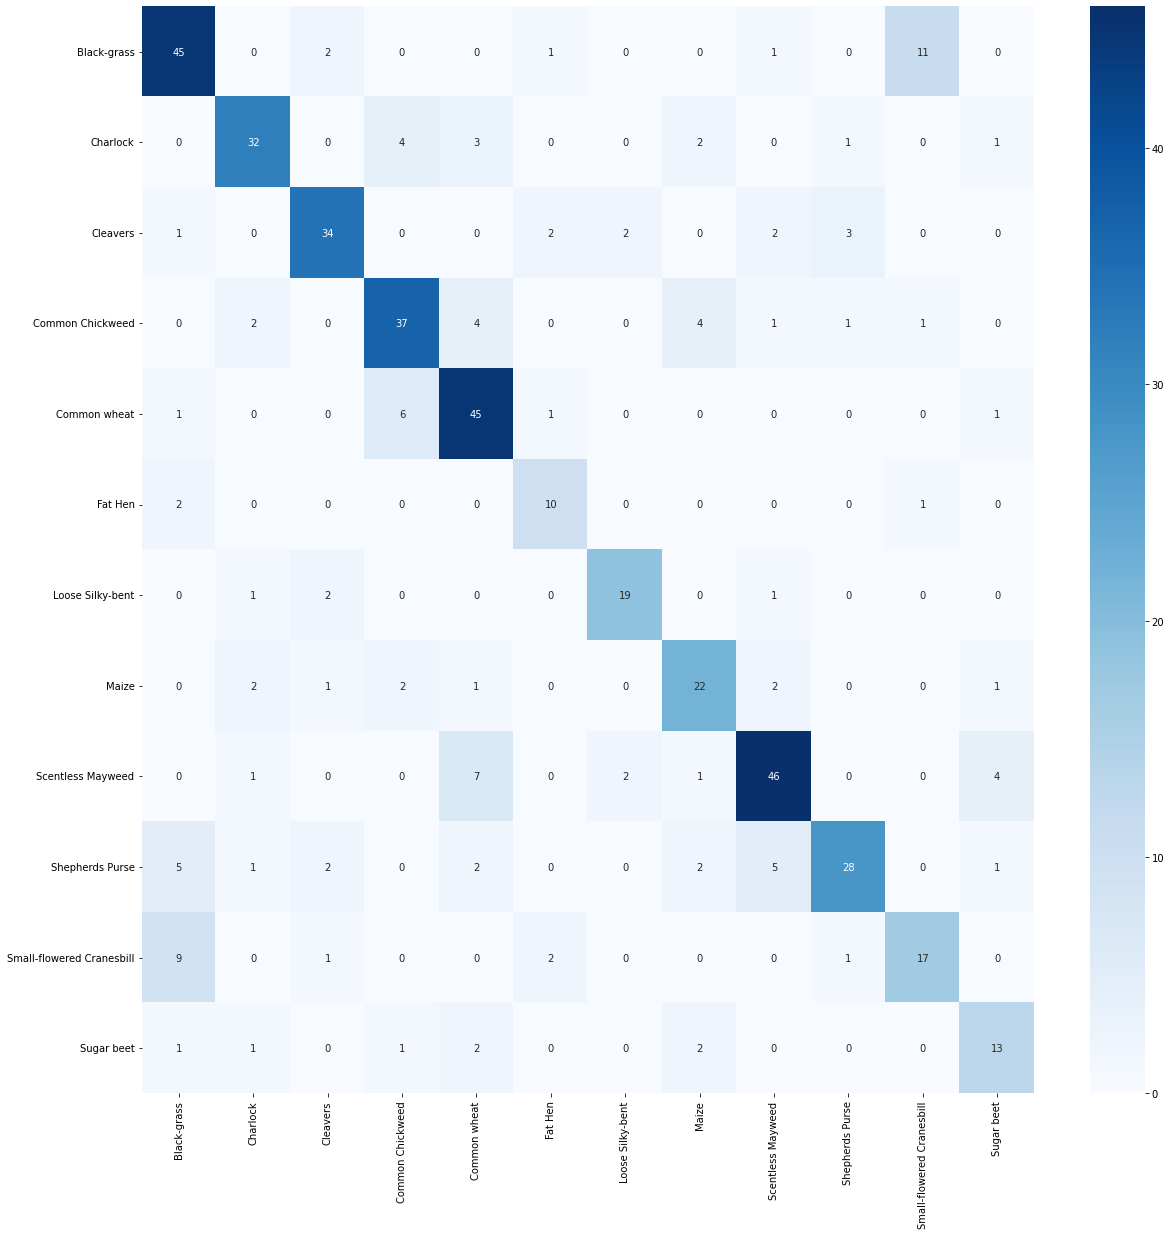

In [ ]:
conf_matrix(model_for_pruning)

Pruning involves removal of nodes that do not add predictive power to the model.

As seen above, applying pruning to add sparsity to the model leads to significantly higher accuracy.

# Inception

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape = (256, 256, 3), include_top = False, weights = 'imagenet',pooling='avg')
for layer in inception.layers[:200]:
    layer.trainable = False

inception.summary()

In [ ]:
x = layers.Flatten()(inception.output)

x = layers.Dropout(0.5)(x)

x = layers.Dense(12, activation='softmax')(x)

model_inc = tf.keras.models.Model(inception.input, x)

model_inc.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [ ]:
batch_size = 64

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.000001,verbose=2)
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=7, verbose=2, mode='min')

inc_hist = model_inc.fit(train,
          batch_size=64,
          epochs=20,
          verbose=1, validation_data=val, callbacks=[reduce_lr, early_stop])

In [ ]:
model_inc.save('inception_model')

In [ ]:
plt.figure(figsize=(14,5))

plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(inc_hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(inc_hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(inc_hist.history['loss'], color='b', label='Training Loss')
plt.plot(inc_hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
conf_matrix(model_inc)

In [ ]:
class_report(model_inc)

Optimization of VGG Model with TensorRT

TF-TRT FP32 model

In [ ]:
print('Converting to TF-TRT FP32...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=80000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/vgg_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP32')
print('Done Converting to TF-TRT FP32')

In [ ]:
!saved_model_cli show --all --dir '/content/vgg_saved_model_TFTRT_FP32'

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
batch_size = 16
batched_input = np.zeros((batch_size, 128, 128, 3), dtype=np.float32)

for i in range(batch_size):
    img_path = '/content/gdrive/MyDrive/train_mod/Black-grass'
    for j in os.listdir(img_path):
        img = image.load_img(os.path.join(img_path,j), target_size=(128, 128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        batched_input[i, :] = x
batched_input = tf.constant(batched_input)
print('batched_input shape: ', batched_input.shape)

In [ ]:
def benchmark_tftrt(input_saved_model):
    saved_model_loaded = tf.saved_model.load(input_saved_model, tags=[tf.compat.v1.saved_model.tag_constants.SERVING])
    infer = saved_model_loaded.signatures['serving_default']

    N_warmup_run = 50
    N_run = 500
    elapsed_time = []

    for i in range(N_warmup_run):
        labeling = infer(batched_input)

    for i in range(N_run):
        start_time = time.time()
        labeling = infer(batched_input)
        #prob = labeling['probs'].numpy()
        end_time = time.time()
        elapsed_time = np.append(elapsed_time, end_time - start_time)
        if i % 50 == 0:
            print('Step {}: {:4.1f}ms'.format(i, (elapsed_time[-50:].mean()) * 1000))

    print('Throughput: {:.0f} images/s'.format(N_run * batch_size / elapsed_time.sum()))

In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP32')

TF-TRT FP16 model

In [ ]:
print('Converting to TF-TRT FP16...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.FP16,
    max_workspace_size_bytes=8000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/vgg_model',
                                    conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_FP16')
print('Done Converting to TF-TRT FP16')

In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_FP16')

TF-TRT INT8 model

In [ ]:
print('Converting to TF-TRT INT8...')
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode=trt.TrtPrecisionMode.INT8, 
    max_workspace_size_bytes=8000000000, 
    use_calibration=True)
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='/content/vgg_model', 
    conversion_params=conversion_params)

def calibration_input_fn():
    yield (batched_input, )
converter.convert(calibration_input_fn=calibration_input_fn)

converter.save(output_saved_model_dir='vgg_saved_model_TFTRT_INT8')
print('Done Converting to TF-TRT INT8')

In [ ]:
benchmark_tftrt('vgg_saved_model_TFTRT_INT8')

Model Optimization Using TF-Lite(Post Training Dynamic range quantization)

In [ ]:
import pathlib

In [ ]:
tflite_models_dir = pathlib.Path(os.path.join(os.getcwd(),'tflite_models'))
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
converter_vgg = tf.lite.TFLiteConverter.from_saved_model('./vgg_model')

In [ ]:
vgg16_tflite_file = tflite_models_dir/"vgg16.tflite"
converter_vgg.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
vgg16_tflite_file.write_bytes(converter_vgg.convert())
tflite_quant_model = converter_vgg.convert()

In [ ]:
interpreter = tf.lite.Interpreter(model_path='./tflite_models/vgg16.tflite')
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
def run_tflite_model(tflite_file, test_image_indices):
    global X_valid

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        test_image = X_valid[test_image_index]
        test_label = Y_valid[test_image_index]

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]

        predictions[i] = output.argmax()

    return predictions

In [ ]:
def evaluate_model(tflite_file, model_type):
    global X_valid
    global Y_valid

    test_image_indices = range(100) #Loading only 100 images for testing since interpreter.invoke takes a lot of time to complete.
    #Reason for longer execution time: TensorFlow Lite op kernels are optimized for ARM processor.
    predictions = run_tflite_model(tflite_file, test_image_indices)
    
    predictions=pd.get_dummies(predictions)
    predictions = np.array(predictions)
    print(predictions.shape)
    accuracy = accuracy_score(y_true=Y_valid[:100,:], y_pred=predictions) 


    return accuracy

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
op = evaluate_model(vgg16_tflite_file, model_type="Float")
print("Accuracy of TFLite - VGG : {}".format(op))

Post training quantization is used for improving latency as well as model size. This could however lead to lower accuracy.

Pruning

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

batch_size = 64
epochs = 100

num_images = len(X_train)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.10,
                                                               final_sparsity=0.30,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, Y_train,
                  batch_size=batch_size, epochs=epochs, validation_data=(X_valid,Y_valid),
                  callbacks=[callbacks, reduce_lr,early_stop])

In [ ]:
class_report(model_for_pruning)

In [ ]:
conf_matrix(model_for_pruning)

# Resnet

In [ ]:
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(input_shape=(256, 256,3), include_top=False, weights="imagenet",pooling='avg')
resnet.summary()
for layer in resnet.layers[:80]:
    layer.trainable = False

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
x = layers.Flatten()(resnet.output)

x = layers.Dense(12, activation='softmax')(x)

model = tf.keras.models.Model(resnet.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = 'categorical_crossentropy',metrics = ['accuracy'])


In [ ]:
mc_res = ModelCheckpoint('best_model_resnet.h5', monitor='val_accuracy', mode='max', save_best_only=True)
resnet_history = model.fit(X_train,y_train, validation_data = (X_val,y_val), batch_size=64, epochs = 10,callbacks=[mc_res])

In [ ]:
plt.xlabel("Number of Epochs")
plt.ylabel('Accuracy', fontsize=16)
plt.plot(resnet_history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(resnet_history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.suptitle('Train Results', fontsize=10)
plt.xlabel("Number of Epochs")
plt.ylabel('Loss', fontsize=16)
plt.plot(resnet_history.history['loss'], color='b', label='Training Loss')
plt.plot(resnet_history.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
resnet_model = load_model('best_model_resnet.h5')

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score 
y_pred = resnet_model.predict(X_val)
y_pred = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_val, axis = 1) 

cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred))